# Prevendo preços de imóveis no Brazil (Data Pipeline)

<img src="rj_imoveis.jpg" width=800>

#### O intuito do projeto é criar uma solução "end to end" simulando as etapas de um projeto real usando algumas ferramentas da Google Cloud Platform

Passamos pelas seguintes fases:
1. Criar um Banco de Dados MySQL na nuvem
2. Adicionar mais uma fonte de dados pelo Google Storage
3. Criar o processo de ETL com o Google DataPrep
4. Carregar os dados no Google BigQuery (usando um método mais parecido com Data Warehouse)
5. Extrair os dados para um arquivo Jupyter Notebook para criar análises
6. Fazer o deploy de um modelo de Machine Learning usando o Streamlit.

Abaixo podemos ver um fluxograma:

<img src="end-to-end-ml.png" width=800>

***
# Sobre o dataset
### Este conjunto de dados possui as seguintes informações:
- cidade: Cidade onde o imóvel está localizada
- area: Área do imóvel (em m2)
- quartos: Número de quartos
- banheiros: Número de banheiros
- vagas: Número de vagas
- andar: Em qual andar se localiza
- animal: Se aceita animais
- mobilia: Se está mobiliada
- valor_condominio: Valor do condomínio
- valor_aluguel: Valor do aluguel
- iptu: Valor do IPTU
- taxa_incendio: Valor da taxa de incêndio
- valor_total: Valor total à pagar

### Antes de começar a construir nosso algoritmo, iremos responder as seguintes perguntas de negócios:
1. Qual a cidade que possui o maior número de imóveis disponíveis?
2. Qual a cidade que possui a média do valor total do imóvel mais alta? E a mais baixa?
3. Os imóveis que já possuem mobília são mais caros, mais baratos ou não influenciam no valor total?
4. Imóveis que permitem animais influenciam no valor total?
5. Qual é a média do valor total dos imóveis com 3 quartos ou mais, já possuem mobília e são da cidade com o maior custo total?

**HANDS ON!** 💻

# 1.0 - Importando o conjunto de dados direto do Google BigQuery

In [1]:
# importando as bibliotecas que iremos utilizar nessa primeira parte do projeto
# as outras vou importando ao longo do código quando necessário

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# importando a biblioteca contendo as funções para conexão com o bigquery
from google.cloud import bigquery

In [3]:
# instanciando um client para o bigquery service
bigquery_client = bigquery.Client()

In [4]:
# fazendo a query para trazer os dados
QUERY = """
SELECT *
FROM datawarehousetest-334522.datasets.houses_in_brazil
"""

In [5]:
# rodando a query e pegando os dados
query_job = bigquery_client.query(QUERY)

In [6]:
# converter os dados em um datafram
df = query_job.to_dataframe()

In [7]:
# verificando os dados
df.head(20)

,cidade,area,quartos,banheiros,vagas,andar,animal,mobilia,valor_condominio,valor_aluguel,iptu,taxa_incendio,valor_total
0,Campinas,50,1,1,0,8,aceito,nao mobiliado,300,550,0,3,853
1,Campinas,40,1,2,1,7,aceito,nao mobiliado,550,807,43,3,1403
2,Campinas,25,1,1,0,3,nao aceito,nao mobiliado,200,1020,0,4,1224
3,São Paulo,71,1,1,0,1,aceito,nao mobiliado,718,1443,0,5,2166
4,São Paulo,43,1,1,0,6,aceito,nao mobiliado,219,1472,42,6,1739
5,São Paulo,48,1,1,1,19,aceito,nao mobiliado,588,1525,0,6,2119
6,São Paulo,67,1,1,1,1,nao aceito,nao mobiliado,0,1000,0,6,1006
7,Rio de Janeiro,50,1,1,0,1,aceito,nao mobiliado,640,1428,81,6,2155
8,Belo Horizonte,22,1,1,0,1,aceito,nao mobiliado,30,450,13,6,499
9,Campinas,44,1,1,0,7,aceito,nao mobiliado,350,550,12,7,919


In [8]:
# checando as informações básicas dos dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8510 entries, 0 to 8509
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cidade            8510 non-null   object
 1   area              8510 non-null   int64 
 2   quartos           8510 non-null   int64 
 3   banheiros         8510 non-null   int64 
 4   vagas             8510 non-null   int64 
 5   andar             8510 non-null   int64 
 6   animal            8510 non-null   object
 7   mobilia           8510 non-null   object
 8   valor_condominio  8510 non-null   int64 
 9   valor_aluguel     8510 non-null   int64 
 10  iptu              8510 non-null   int64 
 11  taxa_incendio     8510 non-null   int64 
 12  valor_total       8510 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 864.4+ KB


In [9]:
df.describe()

,area,quartos,banheiros,vagas,andar,valor_condominio,valor_aluguel,iptu,taxa_incendio,valor_total
count,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8.510000e+03,8510.000000,8510.000000,8510.000000,8.510000e+03
mean,148.887309,2.506580,2.235253,1.620094,5.301410,1.082496e+03,3879.462162,336.506580,53.129965,5.351770e+03
std,536.414887,1.171062,1.409261,1.610021,6.028626,1.237611e+04,3406.211183,649.744266,47.850536,1.314085e+04
min,11.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.000000,1.700000e+02,1520.000000,38.250000,21.000000,2.076000e+03
50%,90.000000,2.000000,2.000000,1.000000,3.000000,5.600000e+02,2606.000000,125.000000,36.000000,3.554500e+03
75%,183.000000,3.000000,3.000000,2.000000,8.000000,1.209500e+03,5000.000000,375.000000,66.000000,6.717000e+03
max,46335.000000,13.000000,10.000000,12.000000,301.000000,1.117000e+06,45000.000000,21880.000000,677.000000,1.120000e+06


***

# 2.0 - Respondendo às perguntas de negócios

## 2.1 - Qual a cidade que possui o maior número de imóveis disponíveis?

In [10]:
df['cidade'].value_counts()

São Paulo         4695
Rio de Janeiro    1175
Belo Horizonte     987
Porto Alegre       959
Campinas           694
Name: cidade, dtype: int64

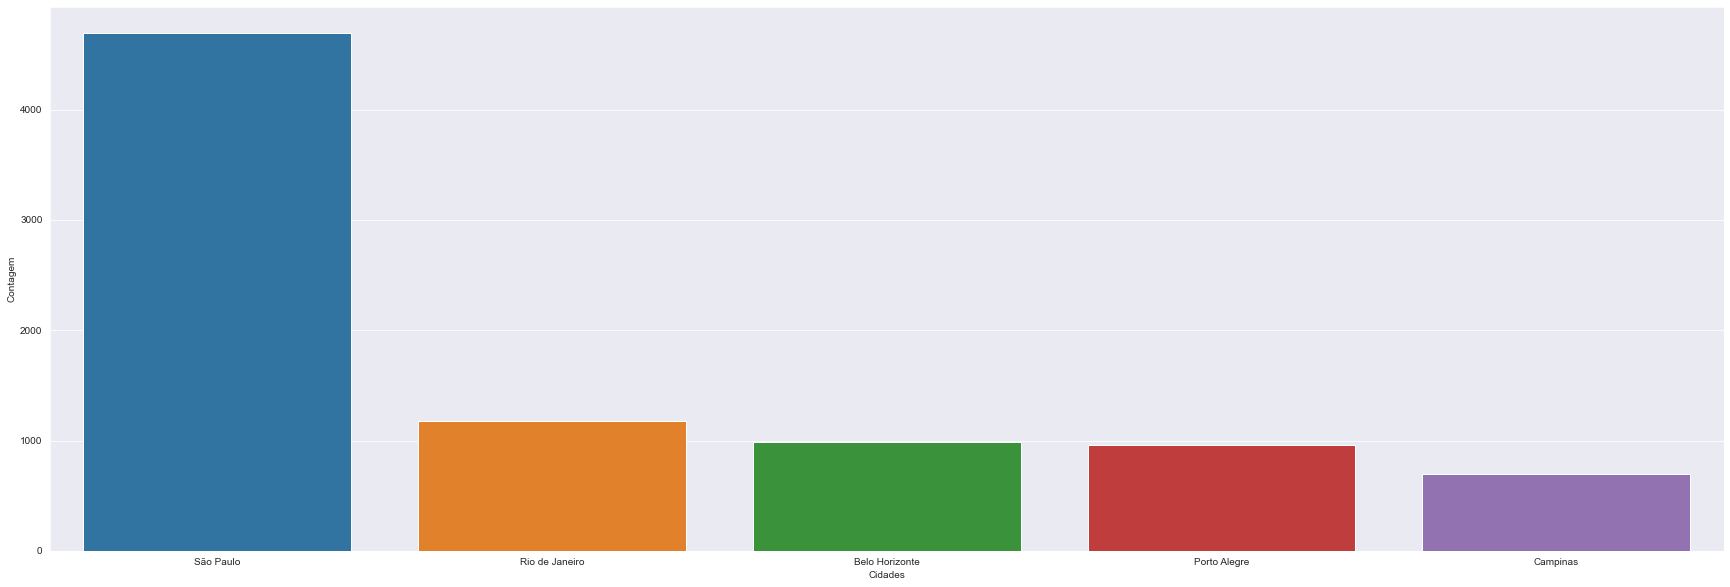

In [11]:
# alterando o estilo do background
sns.set_style("darkgrid")

# o mesmo dado da célula anterior porém em um gráfico
plt.figure(figsize = (30,10))
plot_cidade = ax = sns.countplot(x = 'cidade',
                   data = df,
                  order = df.cidade.value_counts().index)

plot_cidade.set_xlabel("Cidades")
plot_cidade.set_ylabel("Contagem");

In [12]:
(df['cidade'].value_counts() / len(df)).round(2)*100

São Paulo         55.0
Rio de Janeiro    14.0
Belo Horizonte    12.0
Porto Alegre      11.0
Campinas           8.0
Name: cidade, dtype: float64

##### R:. A cidade de São Paulo possui o maior número de imóveis disponíveis correspondendo à 55% de todo o conjunto de dados

## 2.2 - Qual a cidade que possui a média do valor total do imóvel mais alta? E a mais baixa

In [13]:
# verificando se existem valores que estão distorcendo a média da coluna valor_total
# caso os valores de média e mediana sejam muito diferentes, isso indica uma alta probabilidade dos valores estarem muito esparsos
# nesses casos o mais indicado é usar a mediana
# vou criar uma condição que irá retornar se é melhor usar a média ou mediana levando em consideração o valor máximo de diferença de R$500

mean = round(df['valor_total'].mean())
median = round(df['valor_total'].median())
diferenca = mean - median

if diferenca + 500:
    print('Valor da média é {} e da mediana é {} com uma diferença de valores de {}. O melhor caso de uso é a mediana!'.format(mean, median, diferenca))
else:
    print('Valor da média é {} e da mediana é {} com uma diferença de valores de {}. A média pode ser usada com segurança!'.format(mean, median, diferenca))

Valor da média é 5352 e da mediana é 3554 com uma diferença de valores de 1798. O melhor caso de uso é a mediana!


In [14]:
# checando o valor_total máximo e mínimo
max = df['valor_total'].max()
min = df['valor_total'].min()

print('Máximo: {} '.format(max) + '\n' + 'Mínimo: {}'.format(min))

Máximo: 1120000 
Mínimo: 499


In [15]:
# verificando a mediana do valor_total das cidades
df_mediana = df[['cidade','valor_total']]

df_mediana = df_mediana.groupby(by = ['cidade']).median().sort_values(by = 'valor_total', ascending = False)
df_mediana

,valor_total
cidade,
São Paulo,4510
Rio de Janeiro,3324
Belo Horizonte,3091
Porto Alegre,2242
Campinas,2148


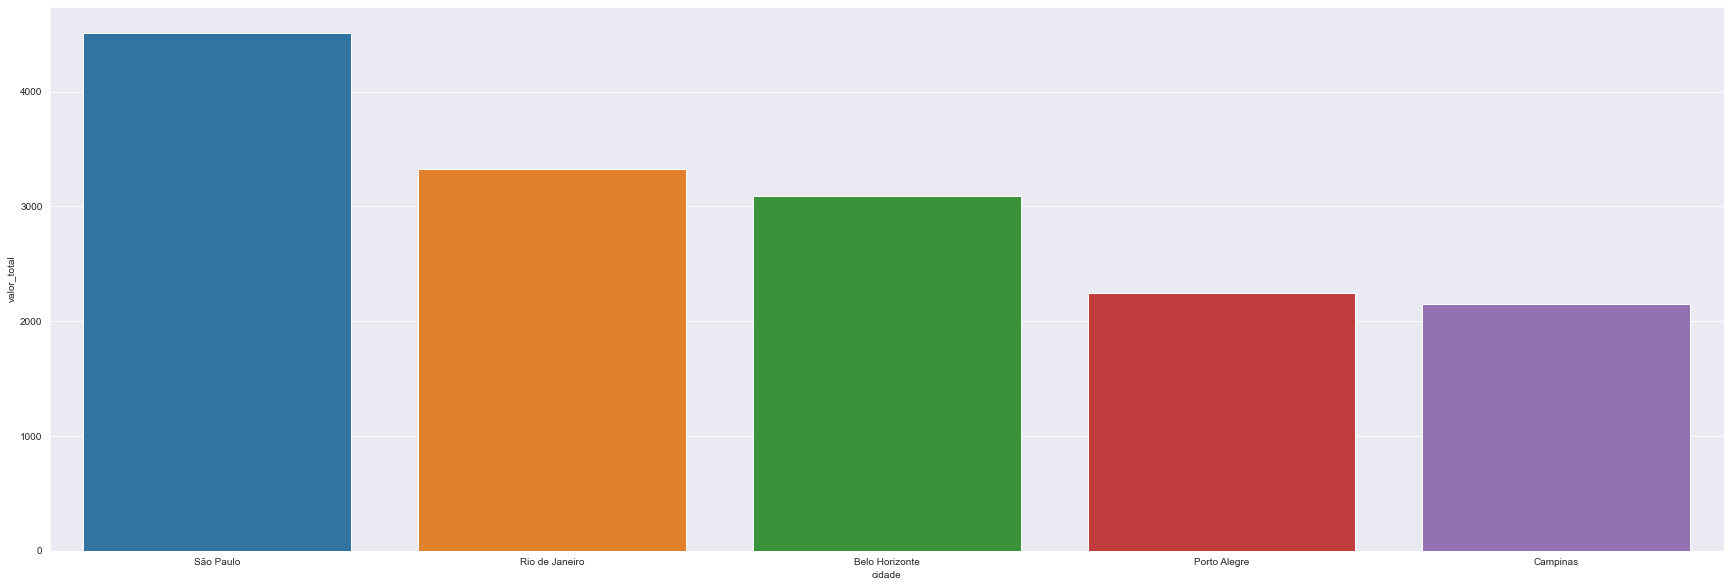

In [16]:
# plotando o gráfico para visualização

df_mediana.reset_index(inplace=True)

fig = plt.subplots(figsize=(30,10))
ax = sns.barplot(x='cidade',
            y='valor_total',
            data=df_mediana);

##### R:. A cidade de São Paulo possui a média mais cara, na faixa de BRL 4510,00, enquanto que a cidade de Campinas possui o menor custo dentre as 5, na faixa de BRL 2148,00. Pelo fato de São Paulo ser uma capital e Campinas ser interior, existe essa diferença de custo de habitação.

## 2.3 Os imóveis que já possuem mobília são mais caros, mais baratos ou não influenciam no valor total?

In [17]:
# vamos usar um gráfico de dispersão e para isso precisamos tirar uma amostra da nossa base de dados pois o swarm demora muito para processar
# nossa base possui 8510 registros e vamos retirar 20% para uma amostra (1702)

df2 = df.sample(1702)
df2.shape

(1702, 13)

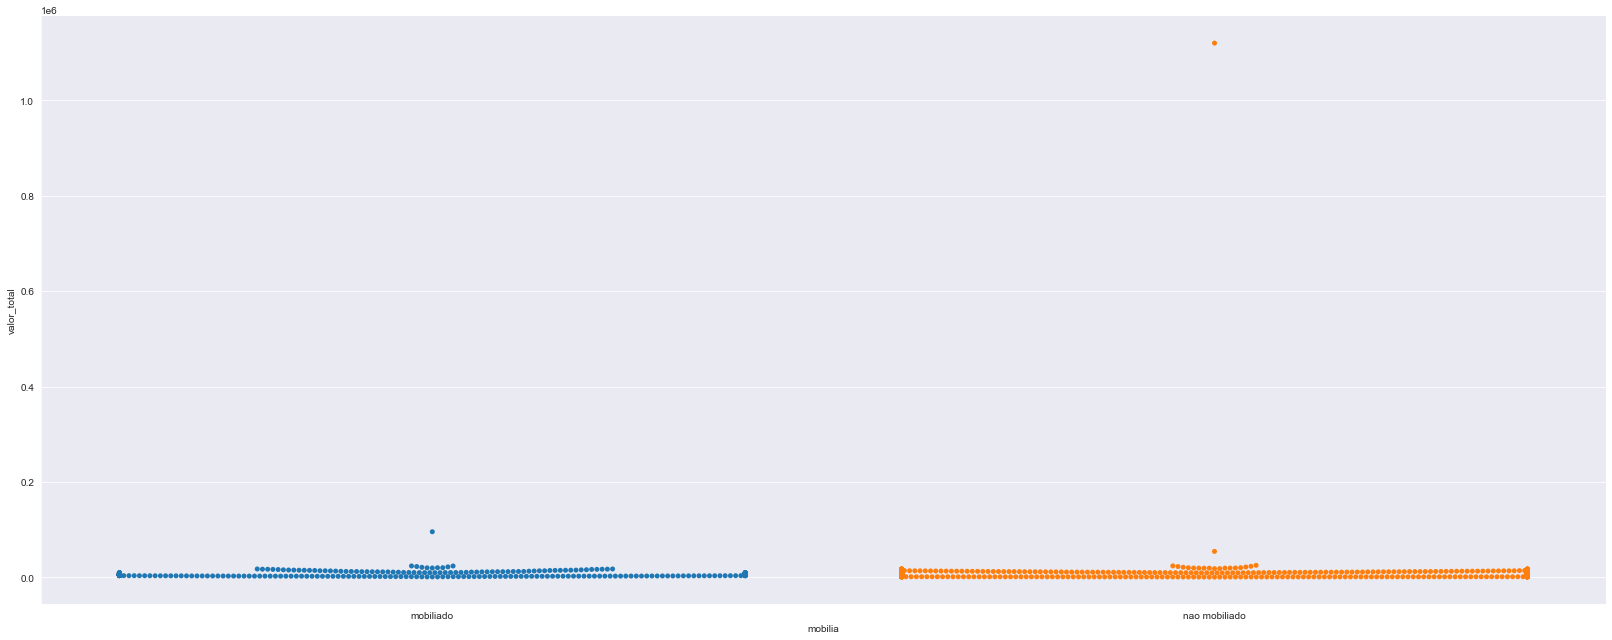

In [18]:
sns.catplot(x="mobilia",
            y="valor_total",
            kind="swarm",
            data=df2,
            height=9,
            aspect=2.5)

In [19]:
df2['mobilia'].value_counts()

nao mobiliado    1287
mobiliado         415
Name: mobilia, dtype: int64

##### R:. Podemos ver que possuem mais imóveis que não estão mobiliados, mas isso necessariamente não interfere no aumento ou diminuição de preços. A correlação é neutra.

## 2.4 - Imóveis que permitem animais influenciam no valor total?

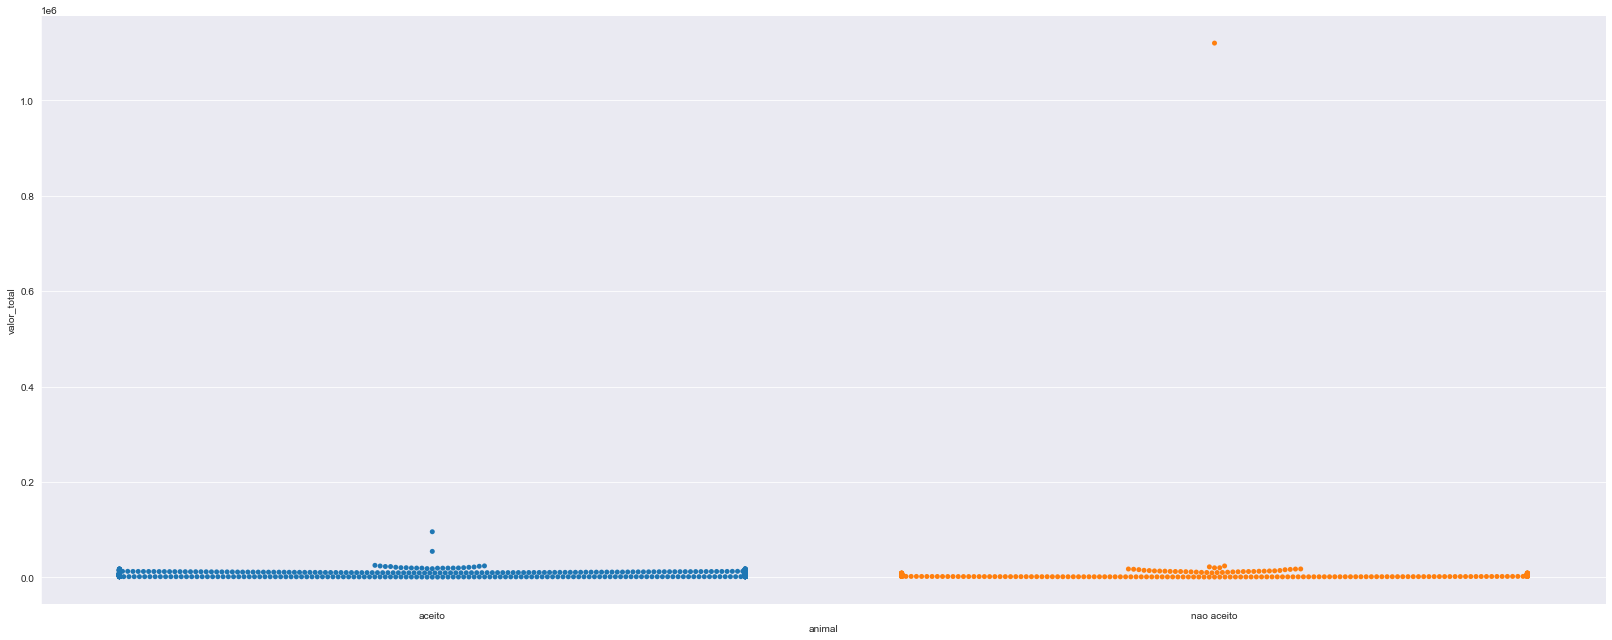

In [20]:
# esta pergunta basicamente pode ser respondida usando o mesmo método da pergunta anterior: visualizando se existe correlação
# e mais uma vez vamos usar a amostra que tiramos

sns.catplot(x="animal",
            y="valor_total",
            kind="swarm",
            data=df2,
            height=9,
            aspect=2.5)

In [21]:
df2['animal'].value_counts()

aceito        1322
nao aceito     380
Name: animal, dtype: int64

##### R:. Podemos ver que mais uma vez a correlação é basicamente neutra. O valor não é influenciado pela aceitação ou não de animais. Existe um claro desbalanceamento das classes mas não precisamos nos preocupar com isso neste momento

## 2.5 - Qual é a média do valor total dos imóveis com 3 quartos ou mais, já possuem mobília e são da cidade com o maior custo total?

In [22]:
# para resolver essa questão precisamos filtrar pelas condições e tirar a mediana (lembrando que nossa média está afetada pela grande variação de valor)
# lembrando que a cidade com maior custo total é São Paulo, como já conferimos mais acima

df['valor_total'].loc[(df['quartos'] >= 3) & (df['mobilia'].str.contains("mobiliado")) & (df['cidade'].str.contains("São Paulo"))].median()

7475.0

##### R:. A média dos imóveis com essas condições é de BRL 7475,00. Bem carinho, hein 😂

***

# 3.0 - Criando nosso algoritmo de Machine Learning

### Realizada as nossas análises e respondido nossas perguntas de negócio, agora vamos partir para a criação do nosso algoritmo de Machine Learning!

Baseados nos atributos do nosso conjunto de dados iremos predizer o valor total de aluguel de um imóvel.<br> A saída do nosso algoritmo será um número (BRL) por isso iremos usar uma técnica de Regressão Supervisionada.<br> Para o baseline iremos usar o algoritmo **Regressão Linear.**<br><br>

Iremos utilizar o **método cíclico** para poder gerar valor mais rápido. Em outras palavras: nesta primeira sprint, não iremos nos preocupar com hiper-parametros, ajustes e nem nada que possa nos atrasar na criação do nosso baseline. Nos próximos ciclos iremos agregar mais passos à nossa solução e ela se tornará bem robusta. Isso permite que criemos um ecossistema de valor em que vamos explorando nosso modelo à medida que o ciclo se repete.

## 3.1 - CICLO 1 - Predição sem culpa (é só um teste ainda)

O algoritmo Regressão Linear aceita somente valores númericos nas suas features e por isso vamos precisar fazer um processo nos dados para que ele possa ser entendido pelo modelo.

In [24]:
# fazendo uma cópia dos nossos dados
df_ml = df.copy()
df_ml.sample(5)

,cidade,area,quartos,banheiros,vagas,andar,animal,mobilia,valor_condominio,valor_aluguel,iptu,taxa_incendio,valor_total
5486,São Paulo,65,3,2,1,10,nao aceito,nao mobiliado,587,3250,113,42,3992
5112,São Paulo,73,3,2,2,14,aceito,nao mobiliado,550,2520,192,32,3294
1692,Rio de Janeiro,45,1,1,0,1,nao aceito,mobiliado,750,3300,249,43,4342
156,Porto Alegre,37,1,1,0,1,aceito,nao mobiliado,270,650,23,10,953
967,Porto Alegre,53,1,1,0,2,aceito,mobiliado,240,1480,42,22,1784


In [26]:
# dropando todas as colunas de valores exceto o valor total
# dropando também a coluna andar, pois veio com uma transformação errada no ETL da google cloud (considerei os valor "-" como nulos e apliquei a mediana, ficando com valor 1. No entando o valor "-" significava que o imóvel não tinha nenhum andar, ficava no térreo)

dropar_colunas = ['valor_condominio', 'valor_aluguel', 'iptu', 'taxa_incendio', 'andar','cidade', 'animal','mobilia']
df_ml = df_ml.drop(columns = dropar_colunas, axis = 1)

In [27]:
df_ml.head()

,area,quartos,banheiros,vagas,valor_total
0,50,1,1,0,853
1,40,1,2,1,1403
2,25,1,1,0,1224
3,71,1,1,0,2166
4,43,1,1,0,1739


In [29]:
# vamos dividir nossos dados em treino e teste para não vazar nenhuma informação para o modelo

# importando as libs
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [30]:
# dividindo os dados

X = df_ml.drop('valor_total', axis = 1)
y = df_ml['valor_total']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 42)

In [31]:
model_lr = lm.LinearRegression()

In [32]:
# treinando o modelo

model_lr.fit(X_train, y_train)

LinearRegression()

In [33]:
# vendo as predições nos dados de treino

pred = model_lr.predict(X_test)

Text(0, 0.5, 'Y Predito')

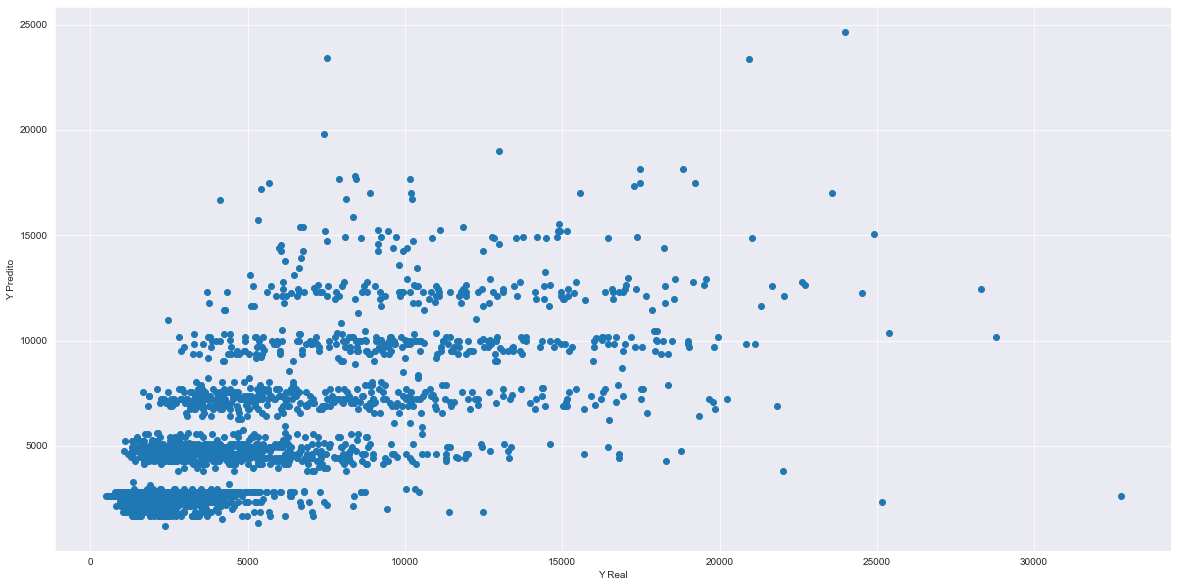

In [34]:
# verificando o resultado do modelo com os dados de teste
# o gráfico está muito esparso, provavelmente nosso modelo não obteve um bom resultado

plt.figure(figsize = (20,10))
plt.scatter(y_test, pred)
plt.xlabel('Y Real')
plt.ylabel('Y Predito')

In [36]:
# visualizando os resultados do nosso modelo

print('MAE: ', metrics.mean_absolute_error(y_test, pred))
print('MSE: ', metrics.mean_squared_error(y_test, pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('R: ', metrics.r2_score(y_test, pred))

MAE:  2171.5591748571683
MSE:  10296859.455408478
RMSE:  3208.8719911221883
R:  0.464317098147358


In [46]:
# salvando o nosso dataset
df_ml.to_csv('dataset_house_prices_in_brazil.csv', index = False)

Podemos ver que o nosso erro absoluto está em 2171, ou seja: toda vez que o modelo predizer o valor total, ele pode errar até BRL 2171 para mais ou para menos. Isso é muito ruim, visto que essa diferença de valores com certeza impactará na avaliação do imóvel.

No entanto estamos ainda no ciclo 1. O objetivo aqui era realizar a criação de um modelo baseline. Nos próximos ciclos poderá ser feito inúmeros passos extras como: avaliar as features, construir novas features, saber quais features possuem alta correlação, tunar nosso modelo, etc. É uma infinidade de coisas possíveis que não iremos realizar neste projeto.

Agora vamos colocar nosso modelo em produção! 🚀

***

# 4.0 - Fazendo o deploy do modelo em produção

### Nesta parte iremos criar o código necessário para conseguir integrar na plataforma Streamlit para os usuários finais utilizarem

#### O código está no arquivo streamlit_app.py